In [1]:
import sys
sys.path.insert(0, "../")
import infercnvpy
import pandas as pd
import pathlib as pl
import numpy as np
import os
import scanpy as sc

import simul.base.utils as utils
import simul.simulate.run as run
import simul.cnv.profiles as cnvprofile
import simul.cnv.sampling as cnvsample
import simul.patients.dataset as patut
from scipy.stats import norm
from simul.base.config import SimCellConfig
from simul.simulate.utils import save_dataset
from scDesign2.model_fitting import calc_u
from scDesign2.data_simulation import simulate_count_scDesign2
import pickle

# first set the random seed
rs = 1
np.random.seed(rs)
anchors = ["CD4","CD8A","CD7"]
adatavar = pd.read_csv("../data/anndata.csv", index_col=0)
print(adatavar.index)
genome = cnvprofile.Genome(genes_df=adatavar, chromosome_column="chromosome", start_column="start")
vartosave = adatavar[["chromosome","start","end"]]

Index(['MALAT1', 'JCHAIN', 'B2M', 'TMSB4X', 'MT-CO1', 'FTL', 'MT-CO2',
       'MT-RNR2', 'MT-CO3', 'MT-ATP6',
       ...
       'METRN', 'LYPLAL1', 'IL17RA', 'ALDH16A1', 'STIM1', 'ANKIB1', 'TRIM26',
       'GNGT2', 'CHMP6', 'LILRB1'],
      dtype='object', length=5000)


In [2]:
CNVGenerator = cnvprofile.CNVPerBatchGenerator(
    genome=genome,
    anchors = anchors,
    chromosomes_gain=["chr1","chr2","chr4","chr5","chr10","chr11","chr14","chr19","chr20"],
    #chromosomes_gain=["chr1","chr4","chr10","chr14","chr20"],
    chromosomes_loss=["chr3","chr6","chr8","chr13","chr16","chr18",],
    #chromosomes_loss=["chr3","chr8","chr16","chr18",],
    # dropout=1, # no cnv
    dropout=0.8, # normal
    # dropout=0.5, # high CNV
    # dropout_child=1, # normal
    dropout_child=0.8, # normal
    # dropout_child=0.5,
    # p_anchor=0, #no anchors
    p_anchor=0.2, #normal
    # p_anchor = 0, #normal
    # min_region_length=400,
    # max_region_length=600,
    min_region_length=200,
    max_region_length=300,
    seed = rs,
)

In [3]:
dataset = patut.Dataset(
    n_batches=20,
    n_programs=3,
    CNVGenerator=CNVGenerator,
    seed=rs,
    n_subclones_min=1,
    n_subclones_max=3,
    n_malignant_max=600,
    n_malignant_min=300,
    n_healthy_max=500,
    n_healthy_min=300,
    # n_malignant_max=800,
    # n_malignant_min=600,
    # n_healthy_max=800,
    # n_healthy_min=500,
    subclone_alpha=5,
)
# utils.plot_subclone_profile(dataset=dataset,filename="figures/heatmap_highcnv_subclones.png")
# for pat in dataset.patients:
#     print(pat.batch, pat.n_total_cells(), pat.subclone_proportions)
anchor_alphas = utils.generate_anchor_alphas(anchors=anchors, alpha_add=10, start_alpha=[5,10,10])
### LEAVE AS IS
MIN_PROGRAMS = 2
DROPOUT = 0
distribution = cnvsample.generate_probabilities(
    anchors_to_alphas=anchor_alphas,
    batches=dataset.batches,
    min_programs=MIN_PROGRAMS,
    prob_dropout=DROPOUT,
    program_names=dataset.programs,
    seed=rs,
)
# distribution._conditional_probability
# celltypes = ["Stem","Enterocyte.Progenitor.Early","program1","program2","program3"]
# healthy_celltypes = ["Stem","Enterocyte.Progenitor.Early"]
celltypes = ["Macro","Plasma","program1","program2","program3"]
healthy_celltypes = ["Macro","Plasma"]
full_obs = run.simulate_full_obs(dataset=dataset, prob_dist=distribution, p_drop = [0.3, 0.2], cell_types_avail=healthy_celltypes)
n_cells = np.sum([full_obs[pat].shape[0] for pat in full_obs])


          subclone   program malignant_key
cell1    ancestral  program3     malignant
cell2    ancestral  program2     malignant
cell3    ancestral  program2     malignant
cell4    ancestral  program2     malignant
cell5    ancestral  program2     malignant
...            ...       ...           ...
cell450  ancestral  program3     malignant
cell451  ancestral  program2     malignant
cell452  ancestral  program2     malignant
cell453     child1  program3     malignant
cell454     child1  program3     malignant

[454 rows x 3 columns]
          subclone   program malignant_key
cell1       child1  program1     malignant
cell2    ancestral  program1     malignant
cell3       child1  program2     malignant
cell4    ancestral  program2     malignant
cell5    ancestral  program2     malignant
...            ...       ...           ...
cell556     child1  program3     malignant
cell557  ancestral  program1     malignant
cell558     child1  program3     malignant
cell559  ancestral  program1  

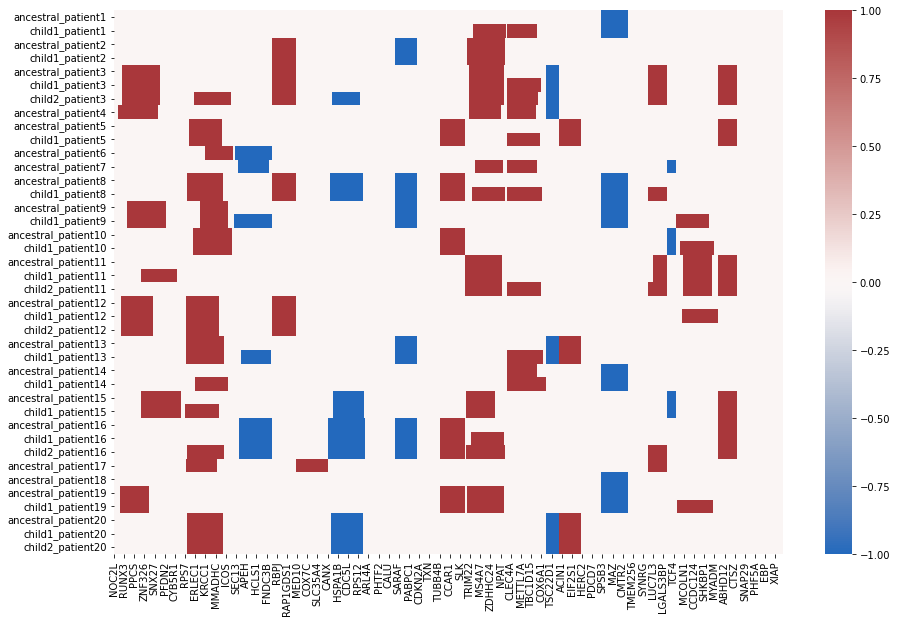

In [4]:
utils.plot_subclone_profile(dataset=dataset,filename="figures/heatmap_highcnv_subclones.png")

In [4]:
config = SimCellConfig(random_seed=rs, 
                        n_genes=adatavar.shape[0], 
                        batch_effect=True,
                        n_cells=n_cells,
                        group_names=celltypes, 
                        batch_names=list(full_obs.keys()),
                        libsize_scale=0.25,
                        libsize_loc=10,
                        p_de_list=np.array([0.2,0.2,0.1,0.1,0.1]), 
                        # p_de_list=np.array([0.1,0.1,0.1,0.1,0.1]), 
                        p_down_list=np.array([0.5,0.5,0.5,0.5,0.5]),
                        # p_down_list=np.array([0,0,0,0,0]), 
                        de_location_list=np.array([0.4,0.4,0.25,0.25,0.25]),
                        # de_location_list=np.array([0.1,0.1,0.1,0.1,0.1]),
                        de_scale_list=np.array([0.1,0.1,0.1,0.1,0.1]), 
                        pb_de_list=0.1,
                        bde_location_list=0.1,
                        # bde_location_list=2,
                        # bde_location_list=0.65, 
                        # bde_location_list=0.8,
                        bde_scale_list=0.1,
                        # bde_scale_list=0.,
                        shared_cnv=False)

rng = config.create_rng()

Splatter

In [5]:
counts, de_facs_group, de_facs_be, gain_expr_full, loss_expr_full = run.simulate_dataset(config=config, 
                                                         rng=rng, 
                                                         full_obs=full_obs, 
                                                         dataset=dataset)

scDesign2

In [6]:
programs = ['program1', 'program2', 'program3']
subclones = ['ancestral', 'child1', 'child2']

counts, de_facs_group, de_facs_be, gain_expr_full, loss_expr_full = run.simulate_dataset_scDesign2(
    config=config, 
    rng=rng, 
    full_obs=full_obs, 
    dataset=dataset,
    healthy_celltypes=healthy_celltypes,
    programs=programs,
    subclones=subclones,
    reference_dataset_path=os.path.dirname(os.path.abspath('')) + '/scDesign2/count_matrices/bcells_100_250_1400_1900_1350_09_05_02_01.csv',
    pickle_path=None,
    # pickle_path=os.path.dirname(os.path.abspath('')) + '/scDesign2/data/copula_result_bcells_100_250_1400_1900_1350_09_05_02_01.pkl',
)


Sampling original mean...


KeyboardInterrupt: 

... storing 'subclone' as categorical
... storing 'program' as categorical
... storing 'malignant_key' as categorical
... storing 'sample_id' as categorical
... storing 'chromosome' as categorical
... storing 'subclone' as categorical
... storing 'program' as categorical
... storing 'malignant_key' as categorical
... storing 'sample_id' as categorical
... storing 'chromosome' as categorical
... storing 'subclone' as categorical
... storing 'program' as categorical
... storing 'malignant_key' as categorical
... storing 'sample_id' as categorical
... storing 'chromosome' as categorical
... storing 'subclone' as categorical
... storing 'program' as categorical
... storing 'malignant_key' as categorical
... storing 'sample_id' as categorical
... storing 'chromosome' as categorical
... storing 'subclone' as categorical
... storing 'program' as categorical
... storing 'malignant_key' as categorical
... storing 'sample_id' as categorical
... storing 'chromosome' as categorical
... storing 'su

patient18
patient7
patient14
patient15
patient6
patient19
patient12
patient1
patient13
patient10
patient3
patient2
patient11
patient20
patient5
patient9
patient16
patient17
patient8
patient4
         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
... storing 'subclone' as categorical
... storing 'program' as categorical
... storing 'sample_id' as categorical
... storing 'pat_subclone' as categorical


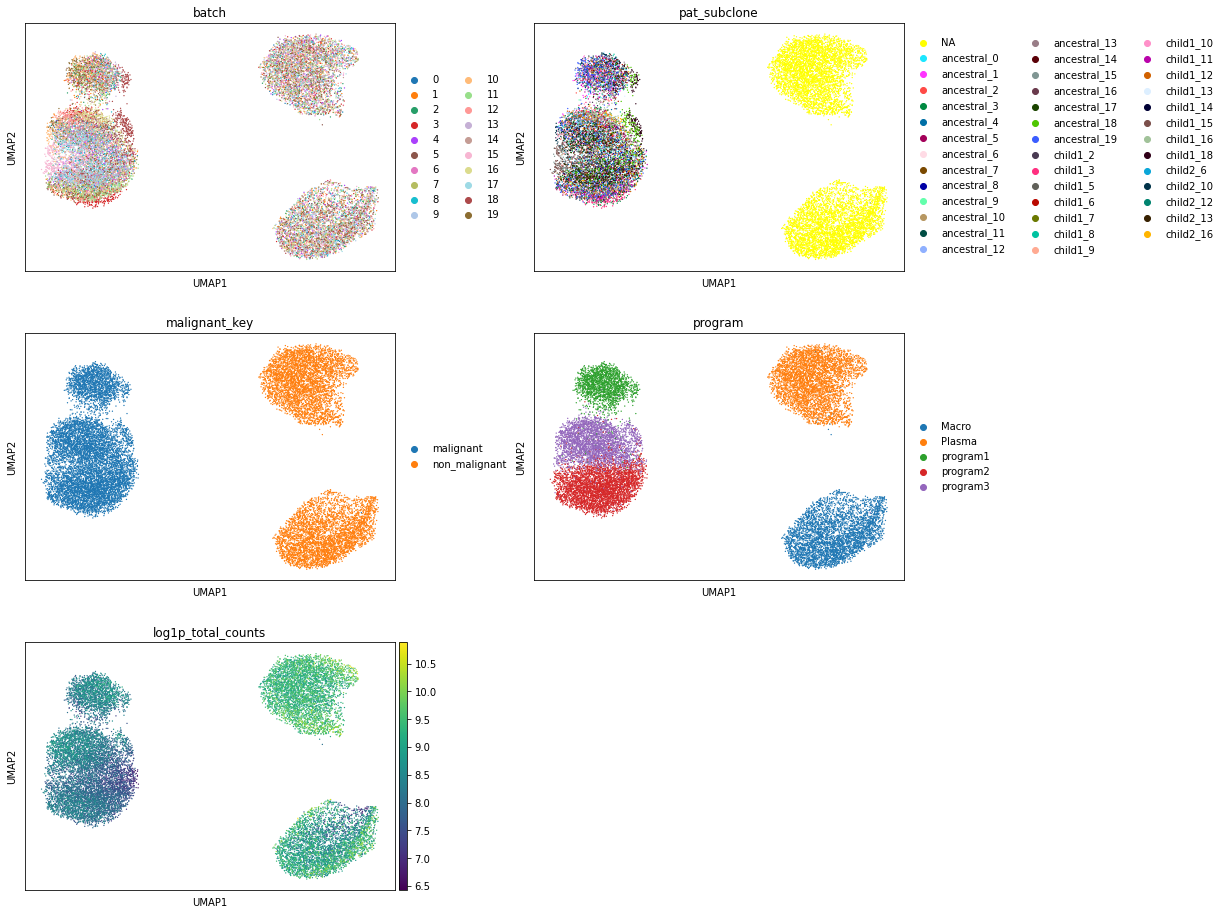

In [6]:
adatas = run.counts_to_adata(counts_pp=counts, 
                         observations=full_obs, var=vartosave)
ds_name = "morecells_2"
savedir = pl.Path("datasets")

save_dataset(adatas=adatas, 
             ds_name=ds_name, 
             savedir=savedir, 
             de_group=pd.DataFrame(de_facs_group),
             de_batch=pd.DataFrame(de_facs_be),
             gain_expr_full=gain_expr_full,
             loss_expr_full=loss_expr_full,
             config=config)

adatas = []
for f in (savedir / ds_name).iterdir():
    if "patient" in f.stem:
        print(f.stem)
        adatas.append(sc.read_h5ad(f))
simadata = adatas[0].concatenate(*adatas[1:])
sc.pp.calculate_qc_metrics(simadata, percent_top=None, log1p=True, inplace=True)

sc.pp.normalize_total(simadata, target_sum=10000)
sc.pp.log1p(simadata)
maladata = simadata[simadata.obs.malignant_key=="malignant"].copy()
sc.pp.highly_variable_genes(maladata, n_top_genes=2000)
simadata = simadata[:,maladata.var.highly_variable].copy()
sc.pp.neighbors(simadata)
sc.tl.umap(simadata)
simadata.obs["pat_subclone"] = simadata.obs.subclone.astype(str) + "_" + simadata.obs.batch.astype(str)
simadata.obs["pat_subclone"] = simadata.obs["pat_subclone"].apply(lambda x: "NA" if "NA" in x else x)
sc.pl.umap(simadata,color=["batch","pat_subclone","malignant_key",
 "program","log1p_total_counts",] ,ncols=2, wspace=0.25,
                 save=f"{ds_name}.png")

# Analyze simulated data

In [15]:
sc.pp.normalize_total(adatas[3],target_sum=10000)
sc.pp.log1p(adatas[3])

In [16]:
infercnvpy.tl.infercnv(adatas[3],reference_key="program",reference_cat=["Macro","Plasma"],window_size=200)

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


/Users/georgye/miniforge3/lib/python3.9/site-packages/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs)


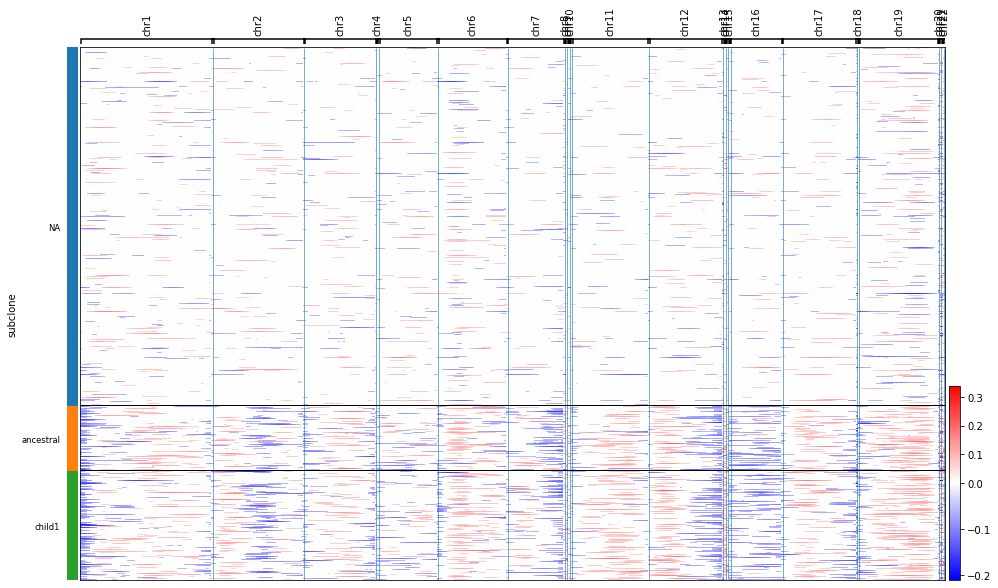

In [17]:
infercnvpy.pl.chromosome_heatmap(adatas[3],groupby="subclone")

In [18]:
utils.plot_cnv_heatmap(dataset=dataset, patient="patient11", var=adatavar)

/Users/georgye/Documents/repos/ethz/bsc_thesis/SplatterSim-mainScDesign2/notebook/../simul/base/utils.py:48: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  cnv_adata = ad.AnnData(pat_subclones.reset_index(drop=True), obs=pat_subclones.reset_index()[["index"]])
/Users/georgye/miniforge3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


ValueError: vmin, vcenter, and vmax must be in ascending order